In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/callcounts/CallCounts.csv


In [54]:
cc=pd.read_csv('/kaggle/input/callcounts/CallCounts.csv')

In [55]:
cc.describe()

,Unnamed: 0,CallCountsPerHour
count,6240.000000,6240.000000
mean,3119.500000,59.791987
std,1801.477172,7.779272
min,0.000000,34.000000
25%,1559.750000,54.000000
50%,3119.500000,60.000000
75%,4679.250000,65.000000
max,6239.000000,87.000000


# The data does not contain hour column, will need to make an estimate to when an hour starts and then we can look at seasonal affects

(array([  21.,  113.,  410., 1305., 1566., 1419.,  959.,  327.,   98.,
          22.]),
 array([34. , 39.3, 44.6, 49.9, 55.2, 60.5, 65.8, 71.1, 76.4, 81.7, 87. ]),
 <BarContainer object of 10 artists>)

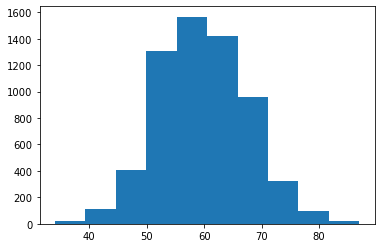

In [56]:
plt.hist(cc['CallCountsPerHour'])

# Lookin at the raw data, It looks like  Normal/Gaussian Distribution with a mean of 60. Lets dive deeper

* There are 6240 rows in the data set. a year has 8760 hpurs. so the Call center is not operating every day or not every hour or niether
* Assuming the Call center operated on 346 days of the year. we get 18 entries per day, so assuming a operating time of 8 am to 12 am
* 1 day is 18 entries
* 1 Month is roughly 520
* Quarter is roughly 2040 rows which we will use as seasons

In [57]:
cc.rename(columns = {'Unnamed: 0':'row'}, inplace = True)

Using Row number we can use the above assumptions to make a hour, day, month and a seasonal column

In [70]:
# convert row number to hours
cc['Hour'] = cc['row'] % 18
#cc['Hour'] = cc['Hour'].apply(lambda x: x if x != 0 else 1)

# convert row number to days
cc['Day'] = (cc['row'] ) // 18 + 1

# convert row number to months
cc['Month'] = (cc['Day'] - 1) // 31
cc['Month'] = cc['Month'] +1

#Convert the day number to quarter
cc['Quarter'] = (cc['row'] ) // 1560 + 1
print(cc)


       row  CallCountsPerHour  Hour  Day  Month  Quarter
0        0                 65     0    1      1        1
1        1                 61     1    1      1        1
2        2                 66     2    1      1        1
3        3                 61     3    1      1        1
4        4                 54     4    1      1        1
...    ...                ...   ...  ...    ...      ...
6235  6235                 63     7  347     12        4
6236  6236                 54     8  347     12        4
6237  6237                 56     9  347     12        4
6238  6238                 63    10  347     12        4
6239  6239                 62    11  347     12        4

[6240 rows x 6 columns]


# checking the tail of data to ensure correct implementatoin of hours and days

In [71]:
print("head of cc")
print(cc.head(30))
print("tail of cc")
print(cc.tail(30))

head of cc
    row  CallCountsPerHour  Hour  Day  Month  Quarter
0     0                 65     0    1      1        1
1     1                 61     1    1      1        1
2     2                 66     2    1      1        1
3     3                 61     3    1      1        1
4     4                 54     4    1      1        1
5     5                 49     5    1      1        1
6     6                 53     6    1      1        1
7     7                 51     7    1      1        1
8     8                 75     8    1      1        1
9     9                 72     9    1      1        1
10   10                 54    10    1      1        1
11   11                 72    11    1      1        1
12   12                 58    12    1      1        1
13   13                 60    13    1      1        1
14   14                 69    14    1      1        1
15   15                 66    15    1      1        1
16   16                 50    16    1      1        1
17   17          

# Next plotting histograms over date time variable for call counts

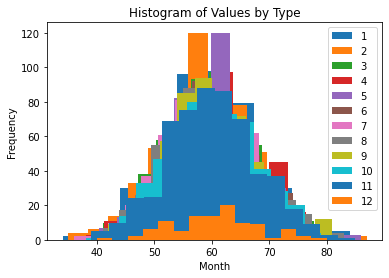

In [72]:
# get the unique values in the Type column
Month = cc['Month'].unique()

# loop through the unique values in the Type column
for type in Month:
    # select data from the Value column for each Type
    data = cc[cc['Month'] == type]['CallCountsPerHour']
    
    # make a histogram for each Type
    plt.hist(data, bins=15, label=type)

# add a title and labels to the histogram
plt.title('Histogram of Values by Type')
plt.xlabel('Month')
plt.ylabel('Frequency')

# add a legend to the histogram
plt.legend()

# display the histogram
plt.show()


# All amonths appear to be Normal/ Gaussian distributed for everymonth

# Repeating the same for Quarters

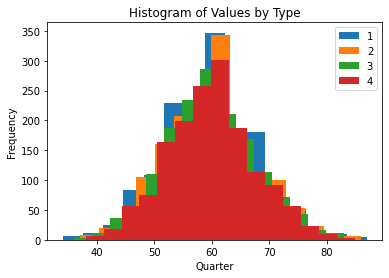

In [73]:
# get the unique values in the Type column
Month = cc['Quarter'].unique()

# loop through the unique values in the Type column
for type in Month:
    # select data from the Value column for each Type
    data = cc[cc['Quarter'] == type]['CallCountsPerHour']
    
    # make a histogram for each Type
    plt.hist(data, bins=15, label=type)

# add a title and labels to the histogram
plt.title('Histogram of Values by Type')
plt.xlabel('Quarter')
plt.ylabel('Frequency')

# add a legend to the histogram
plt.legend()

# display the histogram
plt.show()


Text(0.5, 1.0, 'Seasonality of Call Counts Per Hour')

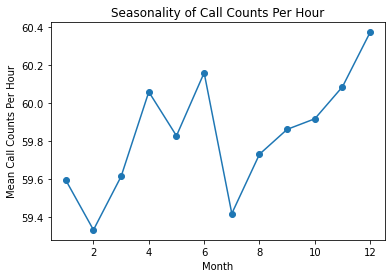

In [74]:
grouped_data = cc.groupby('Month').mean()

# plot the grouped data
grouped_data['CallCountsPerHour'].plot(kind='line', marker='o')

# add labels and title to the plot
plt.xlabel('Month')
plt.ylabel('Mean Call Counts Per Hour')
plt.title('Seasonality of Call Counts Per Hour')

# Her we can see a gradual rise in the mean of Call counts in a month till the Middle of the year, Month 6 seeing the highest distribution.
# The range of means in the months is less than 1 call. which means that all months roughly have the same call volumn overall
* Repeating for quarters

Text(0.5, 1.0, 'Seasonality of Call Counts Per Hour')

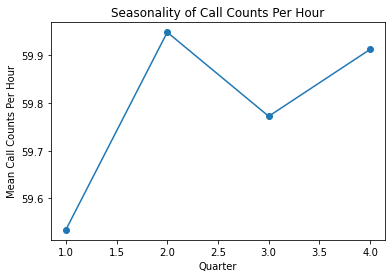

In [75]:
grouped_data = cc.groupby('Quarter').mean()

# plot the grouped data
grouped_data['CallCountsPerHour'].plot(kind='line', marker='o')

# add labels and title to the plot
plt.xlabel('Quarter')
plt.ylabel('Mean Call Counts Per Hour')
plt.title('Seasonality of Call Counts Per Hour')

# We can see the that the first quarter has the lowest mean of CallCounts per hour.
The range in the quarters is less than 1 call. Hence on the face of it There is no seasonality effect


# Lets try to fit a distribution on each quarter and compare the types and if same the mean and variance betwen them

Fitting 106 distributions: 100%|██████████| 106/106 [05:03<00:00,  2.87s/it]


{'gennorm': {'beta': 1.7824931234815096,
  'loc': 59.51082076633857,
  'scale': 10.39749644524813}}

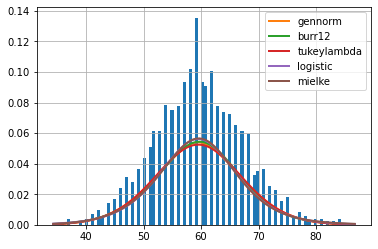

In [89]:
# Using the fitter library 
f = Fitter(cc[cc['Quarter'] == 1]['CallCountsPerHour'],
           distributions= get_distributions())
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

# Using the squared error to see which is the best fitting distribution

# Generalised Normal distribution with beta = 1.78 at mean of 59.5 looks like the best distibution of Quarter 1. Lets repeat the other quarters

Fitting 106 distributions: 100%|██████████| 106/106 [01:50<00:00,  1.04s/it]


{'invgamma': {'a': 254.9766961515279,
  'loc': -64.90829287259805,
  'scale': 31707.7698325424}}

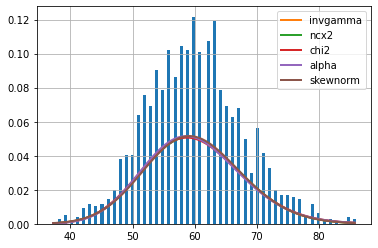

In [88]:
f = Fitter(cc[cc['Quarter'] == 2]['CallCountsPerHour'],
           distributions= get_distributions())
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 106 distributions: 100%|██████████| 106/106 [07:45<00:00,  4.39s/it]


{'dgamma': {'a': 1.5838344801545117,
  'loc': 59.524973629451225,
  'scale': 3.9882644387258526}}

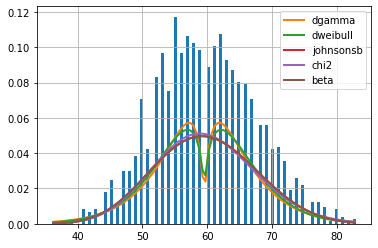

In [90]:
f = Fitter(cc[cc['Quarter'] == 3]['CallCountsPerHour'],
           distributions= get_distributions())
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 106 distributions: 100%|██████████| 106/106 [09:56<00:00,  5.62s/it]


{'chi': {'df': 19.64113267088794,
  'loc': 12.486483733160288,
  'scale': 10.838212255613824}}

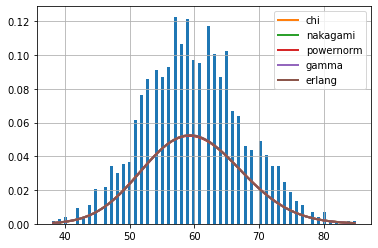

In [91]:
f = Fitter(cc[cc['Quarter'] == 4]['CallCountsPerHour'],
           distributions= get_distributions())
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 10 distributions: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


{'norm': {'loc': 59.91282051282051, 'scale': 7.6108114560187605}}

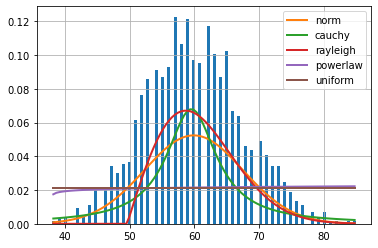

In [92]:
f = Fitter(cc[cc['Quarter'] == 4]['CallCountsPerHour'],
           distributions= get_common_distributions())
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

# Best Distribution fits
1. Quarter  = Genralised Normal 59.5
2. Quarter  = Inverse Gamma at 64.9
3. Quarter  = Double Gamma at 59.5
4. Quarter  = Normal at 59.9 

# In conclusion, All distributions on all 4 quarters are roughly similar even though different. The mean call counts on each month when summed up from a quarter to account for seasonality are within 1